This example generates the transition from /a/ to /i/ using the vocal tract
model and the function vtlSynthBlock(...).

.. note::

    This example uses ``ctypes`` and is very close to the vocaltractlab API.
    This comes with breaking with some standard assumptions one have in python.
    If one wants a more pythonic experience use the ``pyvtl`` wrapper in order
    to use vocaltractlab from python. (pyvtl does not exist yet)

If you are not aware of ``ctypes`` read the following introduction
https://docs.python.org/3/library/ctypes.html

For an in-depth API description look at the `VocalTractLabApi64.h`.

For plotting and saving results you need to install ``matplotlib``, ``numpy``,
and ``scipy``.

In [6]:
 %matplotlib inline

import ctypes
import sys
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [7]:
VTL = ctypes.cdll.LoadLibrary('vtlapi-2.1b/VocalTractLabApi64.so')

In [8]:
version = ctypes.c_char_p(b'                                ')
VTL.vtlGetVersion(version)
print('Compile date of the library: "%s"' % version.value.decode())

Compile date of the library: "Mar 16 2016"


## Initialize vtl

In [9]:
speaker_file_name = ctypes.c_char_p('vtlapi-2.1b/JD2.speaker'.encode())
failure = VTL.vtlInitialize(speaker_file_name)
if failure != 0:
    raise ValueError('Error in vtlInitialize! Errorcode: %i' % failure)

## Get some constants

In [10]:
audio_sampling_rate = ctypes.c_int(0)
number_tube_sections = ctypes.c_int(0)
number_vocal_tract_parameters = ctypes.c_int(0)
number_glottis_parameters = ctypes.c_int(0)

In [11]:
VTL.vtlGetConstants(ctypes.byref(audio_sampling_rate),
                    ctypes.byref(number_tube_sections),
                    ctypes.byref(number_vocal_tract_parameters),
                    ctypes.byref(number_glottis_parameters))

print('Audio sampling rate = %i' % audio_sampling_rate.value)
print('Num. of tube sections = %i' % number_tube_sections.value)
print('Num. of vocal tract parameters = %i' % number_vocal_tract_parameters.value)
print('Num. of glottis parameters = %i' % number_glottis_parameters.value)

Audio sampling rate = 22050
Num. of tube sections = 40
Num. of vocal tract parameters = 24
Num. of glottis parameters = 6


## Get information about the parameters of the vocal tract model

In [12]:
# Hint: Reserve 32 chars for each parameter.
TRACT_PARAM_TYPE = ctypes.c_double * number_vocal_tract_parameters.value
tract_param_names = ctypes.c_char_p((' ' * 32 * number_vocal_tract_parameters.value).encode())
tract_param_min = TRACT_PARAM_TYPE()
tract_param_max = TRACT_PARAM_TYPE()
tract_param_neutral = TRACT_PARAM_TYPE()

VTL.vtlGetTractParamInfo(tract_param_names,
                         ctypes.byref(tract_param_min),
                         ctypes.byref(tract_param_max),
                         ctypes.byref(tract_param_neutral))

print('Vocal tract parameters: "%s"' % tract_param_names.value.decode())
print('Vocal tract parameter minima: ' + str(list(tract_param_min)))
print('Vocal tract parameter maxima: ' + str(list(tract_param_max)))
print('Vocal tract parameter neutral: ' + str(list(tract_param_neutral)))

Vocal tract parameters: "HX HY JX JA LP LD VS VO WC TCX TCY TTX TTY TBX TBY TRX TRY TS1 TS2 TS3 TS4 MA1 MA2 MA3"
Vocal tract parameter minima: [0.0, -6.0, -0.5, -7.0, -1.0, -2.0, 0.0, -0.1, 0.0, -3.0, -3.0, 1.5, -3.0, -3.0, -3.0, -4.0, -6.0, -1.4, -1.4, -1.4, -1.4, -0.05, -0.05, -0.05]
Vocal tract parameter maxima: [1.0, -3.5, 0.0, 0.0, 1.0, 4.0, 1.0, 1.0, 1.0, 4.0, 1.0, 5.5, 2.5, 4.0, 5.0, 2.0, 0.0, 1.4, 1.4, 1.4, 1.4, 0.3, 0.3, 0.3]
Vocal tract parameter neutral: [1.0, -4.75, 0.0, -2.0, -0.07, 0.95, 0.0, -0.1, 0.0, -0.4, -1.46, 3.5, -1.0, 2.0, 0.5, 0.0, 0.0, 0.0, 0.06, 0.15, 0.15, -0.05, -0.05, -0.05]


## Get information about the parameters of glottis model

In [13]:
# Hint: Reserve 32 chars for each parameter.
GLOTTIS_PARAM_TYPE = ctypes.c_double * number_glottis_parameters.value
glottis_param_names = ctypes.c_char_p((' ' * 32 * number_glottis_parameters.value).encode())
glottis_param_min = GLOTTIS_PARAM_TYPE()
glottis_param_max = GLOTTIS_PARAM_TYPE()
glottis_param_neutral = GLOTTIS_PARAM_TYPE()

VTL.vtlGetGlottisParamInfo(glottis_param_names,
                           ctypes.byref(glottis_param_min),
                           ctypes.byref(glottis_param_max),
                           ctypes.byref(glottis_param_neutral))

print('Glottis parameters: "%s"' % glottis_param_names.value.decode())
print('Glottis parameter minima: ' + str(list(glottis_param_min)))
print('Glottis parameter maxima: ' + str(list(glottis_param_max)))
print('Glottis parameter neutral: ' + str(list(glottis_param_neutral)))

Glottis parameters: "f0 pressure lower_rest_displacement upper_rest_displacement ary_area aspiration_strength "
Glottis parameter minima: [40.0, 0.0, -0.0005, -0.0005, -1e-05, -40.0]
Glottis parameter maxima: [600.0, 2000.0, 0.003, 0.003, 5e-05, 0.0]
Glottis parameter neutral: [120.0, 1000.0, 0.0001, 0.0001, 0.0, -40.0]


## Get the vocal tract parameter values for the vocal tract shapes of /i/ and /a/, which are saved in the speaker file.

In [14]:
shape_name = ctypes.c_char_p(b'a')
params_a = TRACT_PARAM_TYPE()
failure = VTL.vtlGetTractParams(shape_name, ctypes.byref(params_a))
if failure != 0:
    raise ValueError('Error in vtlGetTractParams! Errorcode: %i' % failure)

shape_name = ctypes.c_char_p(b'i')
params_i = TRACT_PARAM_TYPE()
failure = VTL.vtlGetTractParams(shape_name, ctypes.byref(params_i))
if failure != 0:
    raise ValueError('Error in vtlGetTractParams! Errorcode: %i' % failure)

del shape_name

## Synthesize a transition from /a/ to /i/.

In [15]:
duration_s = 4.0  # seconds
frame_rate = 200.0  # Hz
number_frames = int(duration_s * frame_rate)
# within first parenthesis type definition, second initialisation
# 2000 samples more in the audio signal for safety
audio = (ctypes.c_double * int(duration_s * audio_sampling_rate.value + 2000))()
number_audio_samples = ctypes.c_int(0)

In [16]:
# init the arrays
tract_params = (ctypes.c_double * (number_frames * number_vocal_tract_parameters.value))()
glottis_params = (ctypes.c_double * (number_frames * number_glottis_parameters.value))()
tube_areas = (ctypes.c_double * (number_frames * number_tube_sections.value))()
tube_articulators = ctypes.c_char_p(b' ' * number_frames * number_tube_sections.value)

In [17]:
# Create the vocal tract shapes that slowly change from /a/ to /i/ from the first to the last frame.
for ii in range(number_frames):
    # transition linearly from /a/ to /i/
    dd = ii / (number_frames - 1)
    for jj in range(number_vocal_tract_parameters.value):
        tract_params[ii * number_vocal_tract_parameters.value + jj] =\
                (1 - dd) * params_a[jj] + dd * params_i[jj]

    offset_glottis = ii * number_glottis_parameters.value
    # transition F0 in Hz going from 120 Hz down to 100 Hz
    glottis_params[offset_glottis + 0] = 120.0 - 20.0 * (ii / number_frames)

    # Start with zero subglottal pressure and then go to 1000 Pa.
    # Somehow, P_sub must stay at zero for the first two frames - otherwise
    # we get an annoying transient at the beginning of the audio signal,
    # and I (Peter) don't know why this is so at the moment.
    if ii <= 1:
        glottis_params[offset_glottis + 1] = 0.0
    elif ii == 2:
        glottis_params[offset_glottis + 1] = 500.0
    else:
        glottis_params[offset_glottis + 1] = 1000.0

    # use the neutral settings for the rest of glottis parameters
    for jj in range(2, number_glottis_parameters.value):
        glottis_params[offset_glottis + jj] = glottis_param_neutral[jj]

In [18]:
# Call the synthesis function. It may calculate a few seconds.
failure = VTL.vtlSynthBlock(ctypes.byref(tract_params),  # input
                            ctypes.byref(glottis_params),  # input
                            ctypes.byref(tube_areas),  # output
                            tube_articulators,  # output
                            number_frames,  # input
                            ctypes.c_double(frame_rate),  # input
                            ctypes.byref(audio),  # output
                            ctypes.byref(number_audio_samples))  # output
if failure != 0:
    raise ValueError('Error in vtlSynthBlock! Errorcode: %i' % failure)
    
print('First 40 data points for every vector:')
print('  tube_areas: %s' % str(list(tube_areas)[:40]))
print('  tube_articulators: %s' % tube_articulators.value[:40])
print('  audio: %s' % str(list(audio)[:40]))
print('  number_audio_samples: %i' % number_audio_samples.value)

# destroy current state of VTL and free memory
VTL.vtlClose()

First 40 data points for every vector:
  tube_areas: [0.6596210742794555, 0.5351304838747722, 0.43241859148015677, 0.3453775156063032, 0.3397323735291094, 1.9447683680214225, 3.653071718314921, 1.5137573225035448, 0.6856640541138362, 0.46158885010754364, 0.44364750631285654, 0.464266089677307, 0.5355026883385093, 0.7701686965376828, 1.1870068497189614, 1.860312564585621, 1.6587276573467382, 1.721360311008873, 2.1692869752506057, 2.4493457952838713, 3.0595186985436253, 3.5441272795960495, 3.5779089078381277, 3.7993832441953295, 4.162250988729555, 4.400997992820128, 4.40178568384228, 4.210720341932476, 3.969527110997274, 3.5110441049743537, 3.2183011390925835, 2.964600288368072, 2.82589235982672, 2.67356492362003, 2.609365194439345, 2.5770246915206356, 1.703608013302266, 1.5963361430387073, 2.125106699338027, 2.1504765753631534]
  tube_articulators: b'NNNNNNNNNTTTTTTTTTTTTTTTTTTTTTTTTTTTILLL'
  audio: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

0

## Plot and save the audio signal


Close the plot in order to continue.


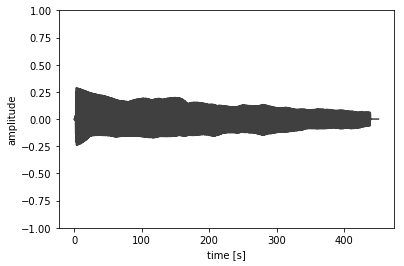

In [19]:
wav = np.array(audio)
time_wav = np.arange(len(wav)) / frame_rate
plt.plot(time_wav, wav, c='black', alpha=0.75)
plt.ylabel('amplitude')
plt.ylim(-1, 1)
plt.xlabel('time [s]')
print('\nClose the plot in order to continue.')
plt.show()

In [20]:
wav_int = np.int16(wav  * (2 ** 15 - 1))
wavfile.write('ai_test.wav', audio_sampling_rate.value, wav_int)
print('saved audio to "ai_test.wav"')

saved audio to "ai_test.wav"


In [21]:
import IPython
IPython.display.Audio("ai_test.wav")